In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/loans.csv',
                 usecols=[
                     'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
                     'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                     'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'
                 ], index_col='SK_ID_CURR')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
SK_ID_CURR,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0


In [3]:
df['TARGET'].value_counts(normalize=True)

0    0.905533
1    0.094467
Name: TARGET, dtype: float64

## Feature Extraction / Transformations

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

y = df.pop('TARGET')
ct = ColumnTransformer(
    [('ohe', OneHotEncoder(), ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']),
     ('scaler', StandardScaler(), ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'])]
)

X = ct.fit_transform(df)

## Conventional Stratified Splitting

In [5]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=y)

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
lr = LogisticRegression(max_iter=1000)
lr.fit(xtrain, ytrain)

LogisticRegression(max_iter=1000)

### Score on training data

In [8]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytrain, lr.predict(xtrain))

0.5

### Score on testing data

In [9]:
roc_auc_score(ytest, lr.predict(xtest))

0.5

In [10]:
## We're underfitting on the training data!

In [20]:
import numpy as np
Cs = np.logspace(-4, 4, 10)

In [21]:
Cs

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [25]:
for c in Cs:
    lr = LogisticRegression(C=c, max_iter=1000)
    lr.fit(xtrain, ytrain)
    score = roc_auc_score(ytrain, lr.predict(xtrain))
    print(f'For alpha={c}, AUC score is {score}')

For alpha=0.0001, AUC score is 0.5
For alpha=0.000774263682681127, AUC score is 0.5
For alpha=0.005994842503189409, AUC score is 0.5
For alpha=0.046415888336127774, AUC score is 0.5
For alpha=0.3593813663804626, AUC score is 0.5
For alpha=2.782559402207126, AUC score is 0.5
For alpha=21.54434690031882, AUC score is 0.5000646705037832
For alpha=166.81005372000558, AUC score is 0.5000646705037832
For alpha=1291.5496650148827, AUC score is 0.5000646705037832
For alpha=10000.0, AUC score is 0.5000646705037832


In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
dt = DecisionTreeClassifier()

In [28]:
dt.fit(xtrain, ytrain)

DecisionTreeClassifier()

In [29]:
roc_auc_score(ytrain, dt.predict(xtrain))

0.9169954083942313

In [30]:
roc_auc_score(ytest, dt.predict(xtest))

0.5040669214018786

In [31]:
# LEt's shuffle, split and check again

In [34]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True)  # shuffle=True is default
dt.fit(xtrain, ytrain)
print('Train score:', roc_auc_score(ytrain, dt.predict(xtrain)))
print('Test score:', roc_auc_score(ytest, dt.predict(xtest)))

Train score: 0.9165750501196404
Test score: 0.5003932205295892


In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

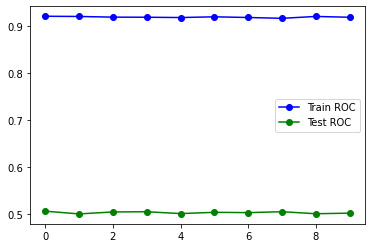

In [39]:
train_scores = []
test_scores = []
for i in range(10):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True)  # shuffle=True is default
    dt.fit(xtrain, ytrain)
    train_scores.append(roc_auc_score(ytrain, dt.predict(xtrain)))
    test_scores.append(roc_auc_score(ytest, dt.predict(xtest)))
plt.plot(train_scores, '-bo', label='Train ROC')
plt.plot(test_scores, '-go', label='Test ROC')
plt.legend()

In [40]:
## Is there a systematic way of doing this?

In [41]:
# K-Fold Cross Validation

![](assets/kfold.png)

In [43]:
from sklearn.model_selection import StratifiedKFold

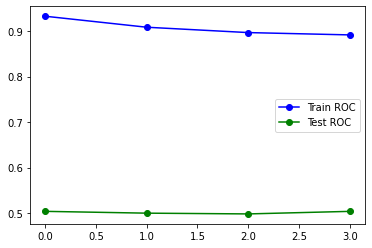

In [51]:
skf = StratifiedKFold(n_splits=4)
train_scores = []
test_scores = []
for train_ix, test_ix in skf.split(X, y):
    xtrain, xtest, ytrain, ytest = X[train_ix], X[test_ix], y.iloc[train_ix], y.iloc[test_ix]
    dt.fit(xtrain, ytrain)
    train_scores.append(roc_auc_score(ytrain, dt.predict(xtrain)))
    test_scores.append(roc_auc_score(ytest, dt.predict(xtest)))
plt.plot(train_scores, '-bo', label='Train ROC')
plt.plot(test_scores, '-go', label='Test ROC')
plt.legend()

In [52]:
# Remember that we haven't touched the model yet!

![](assets/tree.png)

In [65]:
grid = {
    'criterion': ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth': [10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

In [66]:
from sklearn.model_selection import GridSearchCV

In [76]:
gcv = GridSearchCV(dt, grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)

In [77]:
gcv.fit(X, y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   44.5s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='roc_auc', verbose=2)

In [91]:
gcv.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'splitter': 'best'}

In [83]:
dt_best = gcv.best_estimator_

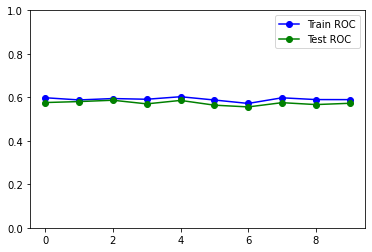

In [87]:
skf = StratifiedKFold(n_splits=10)
train_scores = []
test_scores = []
for train_ix, test_ix in skf.split(X, y):
    xtrain, xtest, ytrain, ytest = X[train_ix], X[test_ix], y.iloc[train_ix], y.iloc[test_ix]
    dt_best.fit(xtrain, ytrain)
    train_scores.append(roc_auc_score(ytrain, dt_best.predict(xtrain)))
    test_scores.append(roc_auc_score(ytest, dt_best.predict(xtest)))
plt.plot(train_scores, '-bo', label='Train ROC')
plt.plot(test_scores, '-go', label='Test ROC')
plt.ylim(0, 1)
plt.legend()

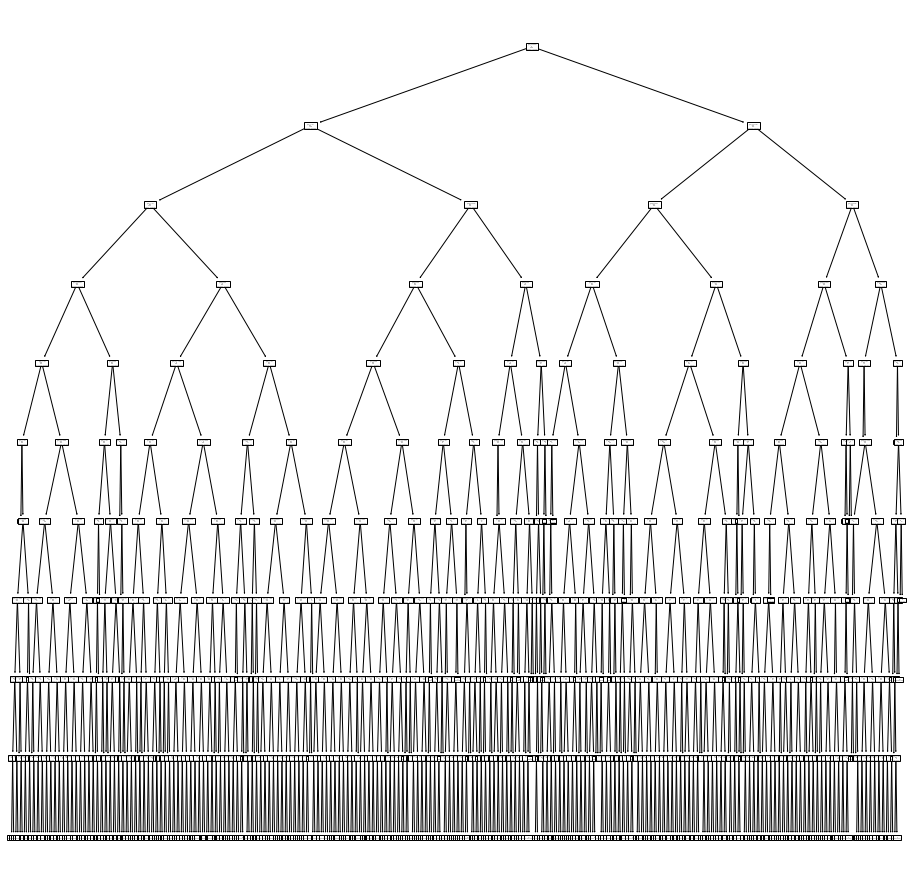

In [90]:
fig, ax = plt.subplots(figsize=(16, 16))
_ = plot_tree(dt_best, label='none')